## DevCon 2018 - Deep Learning (Part 2)


#### Objective

In this session, we are going to build a bunch of neural nets and debug them with tensorboard.

In [1]:
from keras.datasets import mnist
from keras.utils import np_utils
import numpy as np

Using TensorFlow backend.


In [2]:
with np.load('../../data/lab1/mnist.npz') as f:
    train_x, train_y = f['x_train'], f['y_train']
    test_x, test_y = f['x_test'], f['y_test']

print("Training set has length {0} and consists of images of size {1} by {2}".format(*train_x.shape))
print("Testing set has length {0} and consists of images of size {1} by {2}".format(*test_x.shape))

Training set has length 60000 and consists of images of size 28 by 28
Testing set has length 10000 and consists of images of size 28 by 28


### Our data

The first dataset we will work on consists of images of handwritten digits. The task at hand is to classify the image as a digit. These are a few samples from the dataset.

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

samples = train_x[np.random.choice(range(len(train_x)), size=10, replace=False), :, :]

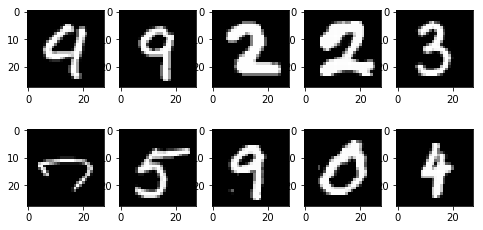

In [4]:
figure = plt.figure(figsize=(8,4))
for i, sample in enumerate(samples):
    ax = figure.add_subplot(2, 5, i+1)
    ax.imshow(sample, cmap='gray')

### Simple feed forward neural net

Our first approach will be to build a simple feed forward net, with no hidden layers. This is equivalent to multinomial logistic regression.

We have to flatten our image data into a one dimensional vector before it can be fed into a simple feed forward neural net. The input has to be normalized before feeding into the neural net. Normalization is done by dividing the each element in the vector by the max (255).

In [5]:
num_train_samples, width, height = train_x.shape
num_test_samples = test_x.shape[0]

flat_train_x = np.reshape(train_x, (num_train_samples, width * height))
flat_test_x  = np.reshape(test_x, (num_test_samples, width * height))

dummied_train_y = np_utils.to_categorical(train_y)
dummied_test_y = np_utils.to_categorical(test_y)

print("Modified training set has length {0} and consists of vectors of size {1}".format(*flat_train_x.shape))
print("Modified testing set has length {0} and consists of vectors of size {1}".format(*flat_test_x.shape))
print("Modified training labels are of size {}".format(dummied_train_y.shape[1]))
print("Modified testing labels are of size {}".format(dummied_test_y.shape[1]))

Modified training set has length 60000 and consists of vectors of size 784
Modified testing set has length 10000 and consists of vectors of size 784
Modified training labels are of size 10
Modified testing labels are of size 10


In [6]:
# normalize your input vectors
# we do 0-1 normalization by dividing by 255
flat_train_x = flat_train_x / 255.0
flat_test_x = flat_test_x / 255.0

In [7]:
from keras.layers import Dense
from keras.models import Sequential

In [8]:
lenet_1 = Sequential()
lenet_1.add(Dense(units=10,
                  name="output",
                  activation="softmax",
                  input_shape=(width * height,)))
lenet_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
output (Dense)               (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [9]:
import os
from keras import backend as K
from lib.default_utils import default_callbacks

K.set_learning_phase(True)  # important if you have modules like dropout in your model

lenet_1.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
logpath, dfcb = default_callbacks(lenet_1, prefix='lenet-1', batch_size=32)

# start training, use tensorboard to show overfitting with more iterations
lenet_1.fit(x=flat_train_x, 
          y=dummied_train_y, 
          batch_size=32, 
          epochs=10, 
          verbose=True, 
          callbacks=dfcb, 
          validation_split=0.2,
          shuffle=True)

# save final weights after completion of training
lenet_1.save_weights(os.path.join(logpath, "model_weights.h5"))



Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 2s 45us/step - loss: 0.8478 - acc: 0.8004 - val_loss: 0.5094 - val_acc: 0.8784
Epoch 2/10
48000/48000 [==============================] - 2s 44us/step - loss: 0.4899 - acc: 0.8743 - val_loss: 0.4180 - val_acc: 0.8942
Epoch 3/10
48000/48000 [==============================] - 2s 44us/step - loss: 0.4280 - acc: 0.8863 - val_loss: 0.3818 - val_acc: 0.9002
Epoch 4/10
48000/48000 [==============================] - 2s 45us/step - loss: 0.3975 - acc: 0.8923 - val_loss: 0.3613 - val_acc: 0.9027
Epoch 5/10
48000/48000 [==============================] - 2s 44us/step - loss: 0.3782 - acc: 0.8965 - val_loss: 0.3474 - val_acc: 0.9065
Epoch 6/10
48000/48000 [==============================] - 2s 44us/step - loss: 0.3646 - acc: 0.8993 - val_loss: 0.3380 - val_acc: 0.9078
Epoch 7/10
48000/48000 [==============================] - 2s 44us/step - loss: 0.3545 - acc: 0.9016 - val_loss: 0.3299 - val_a

[TensorBoard](http://localhost:9001)

In [10]:
# evaluate on test_dataset
_, test_accuracy = lenet_1.evaluate(flat_test_x, dummied_test_y)
print("Model accuracy on test dataset is {:.3f}".format(test_accuracy * 100))

10000/10000 [==============================] - 0s 18us/step
Model accuracy on test dataset is 91.410


### Model with one hidden layer

We add more complexity by adding one hidden layer into our network. We will compare the performance of this network with the previous model using tensorboard.

In [11]:
lenet_2 = Sequential()
lenet_2.add(Dense(units=16,
                  name="hidden_1",
                  activation="relu",
                  input_shape=(width * height,)))

lenet_2.add(Dense(units=10,
                  name="output",
                  activation="softmax"))
lenet_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 16)                12560     
_________________________________________________________________
output (Dense)               (None, 10)                170       
Total params: 12,730
Trainable params: 12,730
Non-trainable params: 0
_________________________________________________________________


In [12]:
## build lenet-2
lenet_2.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
logpath, dfcb = default_callbacks(lenet_2, prefix='lenet-2', batch_size=32)

# start training, use tensorboard to show overfitting with more iterations
lenet_2.fit(x=flat_train_x, 
          y=dummied_train_y, 
          batch_size=32, 
          epochs=20, 
          verbose=True, 
          callbacks=dfcb, 
          validation_split=0.2,
          shuffle=True)

# save final weights after completion of training
lenet_2.save_weights(os.path.join(logpath, "model_weights.h5"))



Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 2s 46us/step - loss: 0.9170 - acc: 0.7563 - val_loss: 0.4447 - val_acc: 0.8820
Epoch 2/20
48000/48000 [==============================] - 2s 45us/step - loss: 0.4206 - acc: 0.8837 - val_loss: 0.3530 - val_acc: 0.8995
Epoch 3/20
48000/48000 [==============================] - 2s 47us/step - loss: 0.3606 - acc: 0.8978 - val_loss: 0.3221 - val_acc: 0.9079
Epoch 4/20
48000/48000 [==============================] - 2s 48us/step - loss: 0.3312 - acc: 0.9058 - val_loss: 0.2996 - val_acc: 0.9147
Epoch 5/20
48000/48000 [==============================] - 2s 50us/step - loss: 0.3111 - acc: 0.9110 - val_loss: 0.2863 - val_acc: 0.9182
Epoch 6/20
48000/48000 [==============================] - 2s 46us/step - loss: 0.2954 - acc: 0.9154 - val_loss: 0.2730 - val_acc: 0.9255
Epoch 7/20
48000/48000 [==============================] - 2s 47us/step - loss: 0.2827 - acc: 0.9201 - val_loss: 0.2623 - val_a

[TensorBoard](http://localhost:9001/)

In [13]:
# evaluate on test_dataset
_, test_accuracy = lenet_2.evaluate(flat_test_x, dummied_test_y)
print("Model accuracy on test dataset is {:.3f}".format(test_accuracy * 100))

10000/10000 [==============================] - 0s 22us/step
Model accuracy on test dataset is 94.320


#### Simple convolutional net

Regular neural nets don't scale well for images. There is structure in images which we can exploit to our advantage. Convolutional neural nets exploit this structure to perform image related tasks.

** Draft **
This explains it better than I could
https://cs231n.github.io/convolutional-networks/

In [14]:
# lenet 3
# 2 convolutional layers - 3x3 and 5x5 patches
from keras.layers import Conv2D, Flatten

lenet_3 = Sequential()
lenet_3.add(Conv2D(filters=32,
                  name="conv_1",
                  kernel_size=(3,3),
                  activation="relu",
                  padding='valid',
                  input_shape=(width, height, 1)))

lenet_3.add(Conv2D(filters=12,
                  kernel_size=(5,5),
                  padding='valid',
                  name="conv_2",
                  activation="relu"))

lenet_3.add(Flatten())
lenet_3.add(Dense(units=10,
                  name='output',
                  activation='softmax'))
lenet_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv_2 (Conv2D)              (None, 22, 22, 12)        9612      
_________________________________________________________________
flatten_1 (Flatten)          (None, 5808)              0         
_________________________________________________________________
output (Dense)               (None, 10)                58090     
Total params: 68,022
Trainable params: 68,022
Non-trainable params: 0
_________________________________________________________________


In [15]:
train_x = train_x / 255.0
test_x = test_x / 255.0

train_x = np.expand_dims(train_x, axis=-1)
test_x = np.expand_dims(test_x, axis=-1)

In [16]:
## build lenet-3
lenet_3.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
logpath, dfcb = default_callbacks(lenet_3, prefix='conv-lenet-3', batch_size=32)
    
# start training, use tensorboard to show overfitting with more iterations
lenet_3.fit(x=train_x, 
            y=dummied_train_y, 
            batch_size=32, 
            epochs=10, 
            verbose=True, 
            callbacks=dfcb, 
            validation_split=0.2,
            shuffle=True)

# save final weights after completion of training
lenet_3.save_weights(os.path.join(logpath, "model_weights.h5"))



Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 83s 2ms/step - loss: 0.4626 - acc: 0.8624 - val_loss: 0.2430 - val_acc: 0.9301
Epoch 2/10
48000/48000 [==============================] - 77s 2ms/step - loss: 0.1862 - acc: 0.9479 - val_loss: 0.1312 - val_acc: 0.9630
Epoch 3/10
48000/48000 [==============================] - 73s 2ms/step - loss: 0.1096 - acc: 0.9681 - val_loss: 0.1101 - val_acc: 0.9684
Epoch 4/10
48000/48000 [==============================] - 83s 2ms/step - loss: 0.0863 - acc: 0.9743 - val_loss: 0.0898 - val_acc: 0.9732
Epoch 5/10
48000/48000 [==============================] - 80s 2ms/step - loss: 0.0733 - acc: 0.9782 - val_loss: 0.0789 - val_acc: 0.9772
Epoch 6/10
48000/48000 [==============================] - 139s 3ms/step - loss: 0.0653 - acc: 0.9803 - val_loss: 0.0711 - val_acc: 0.9784
Epoch 7/10
48000/48000 [==============================] - 170s 4ms/step - loss: 0.0580 - acc: 0.9824 - val_loss: 0.0745 - val

[Tensorboard](http://localhost:9001)

In [17]:
# evaluate on test_dataset
_, test_accuracy = lenet_3.evaluate(test_x, dummied_test_y)
print("Model accuracy on test dataset is {:.3f}".format(test_accuracy * 100))

10000/10000 [==============================] - 12s 1ms/step
Model accuracy on test dataset is 98.320


### Miscellaneous stuff

 - Overfitting
 
 Neural networks are notoriously easy to overfit, make sure your data set is big enough for the model that you are building. Always use a large validation set. Cross-validation can be time consuming.
 
 - Learning rate decay
 
 Always normalize your data before you feed it into the model. Gradient descent can be difficult to converge/tune without normalization

 - optimizers
 
 There is a large variety of optimizers out there - sgd with momentum, adam, rmsprop. We recommend sticking to sgd if you want good generalization. [The Marginal Value of Adaptive Gradient Methods in Machine Learning](https://arxiv.org/abs/1705.08292)
 
 - pooling in convolutional nets
 
 Feature pooling is a way to reduce feature size as you go deeper in the neural net.
 
 - class imbalance
 
 Make sure your classes are balanced

### [Exercise] Add dropout to the model

Dropout is a way to prevent overfitting. add more explanation, insert link to paper.
https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf

In [18]:
from keras.layers import Dropout

lenet_4 = Sequential()
lenet_4.add(Conv2D(filters=32,
                  name="conv_1",
                  kernel_size=(3,3),
                  activation="relu",
                  padding='valid',
                  input_shape=(width, height, 1)))

lenet_4.add(Dropout(0.2))

lenet_4.add(Conv2D(filters=12,
                  kernel_size=(5,5),
                  padding='valid',
                  name="conv_2",
                  activation="relu"))

lenet_4.add(Dropout(0.2))

lenet_4.add(Flatten())
lenet_4.add(Dense(units=10,
                  name='output',
                  activation='softmax'))
lenet_4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
dropout_1 (Dropout)          (None, 26, 26, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 22, 22, 12)        9612      
_________________________________________________________________
dropout_2 (Dropout)          (None, 22, 22, 12)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5808)              0         
_________________________________________________________________
output (Dense)               (None, 10)                58090     
Total params: 68,022
Trainable params: 68,022
Non-trainable params: 0
_________________________________________________________________


In [19]:
lenet_4.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
logpath, dfcb = default_callbacks(lenet_4, prefix='conv-lenet-4-dropout', batch_size=32)
    
# start training, use tensorboard to show overfitting with more iterations
lenet_4.fit(x=train_x, 
            y=dummied_train_y, 
            batch_size=32, 
            epochs=10, 
            verbose=True, 
            callbacks=dfcb, 
            validation_split=0.2,
            shuffle=True)

# save final weights after completion of training
lenet_4.save_weights(os.path.join(logpath, "model_weights.h5"))



Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 182s 4ms/step - loss: 0.4776 - acc: 0.8561 - val_loss: 0.2171 - val_acc: 0.9386
Epoch 2/10
48000/48000 [==============================] - 177s 4ms/step - loss: 0.1744 - acc: 0.9485 - val_loss: 0.1298 - val_acc: 0.9621
Epoch 3/10
48000/48000 [==============================] - 190s 4ms/step - loss: 0.1187 - acc: 0.9649 - val_loss: 0.1128 - val_acc: 0.9674
Epoch 4/10
48000/48000 [==============================] - 200s 4ms/step - loss: 0.0977 - acc: 0.9710 - val_loss: 0.0995 - val_acc: 0.9695
Epoch 5/10
48000/48000 [==============================] - 189s 4ms/step - loss: 0.0877 - acc: 0.9738 - val_loss: 0.0898 - val_acc: 0.9720
Epoch 6/10
48000/48000 [==============================] - 191s 4ms/step - loss: 0.0782 - acc: 0.9761 - val_loss: 0.0813 - val_acc: 0.9748
Epoch 7/10
48000/48000 [==============================] - 189s 4ms/step - loss: 0.0712 - acc: 0.9779 - val_loss: 0.0728 

In [21]:
# evaluate on test_dataset
K.set_learning_phase(False)
_, test_accuracy = lenet_4.evaluate(test_x, dummied_test_y)
print("Model accuracy on test dataset is {:.3f}".format(test_accuracy * 100))

10000/10000 [==============================] - 9s 946us/step
Model accuracy on test dataset is 98.230
